# **1. Imagen de características especio temporales**

In [11]:
import cv2
import tensorflow as tf 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np

In [12]:
base_model=tf.keras.applications.VGG16(
                include_top=False,
                weights='imagenet',
                input_shape=(224,224,3)
            )

In [14]:
model=Sequential()
model.add(base_model)
model.add(Flatten())


In [15]:
model.save('base.h5')

In [6]:
def readVideo(path):
    frames=[]
    vidcap=cv2.VideoCapture(path)
    success,image=vidcap.read()
    
    while success:
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        frames.append(cv2.resize(image,(224,224)))
        success,image=vidcap.read()

    return frames

In [7]:
frames=readVideo("C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/Rviolencia/Real Life Violence Dataset/Violence/V_100.mp4")

In [8]:
len(frames)

153

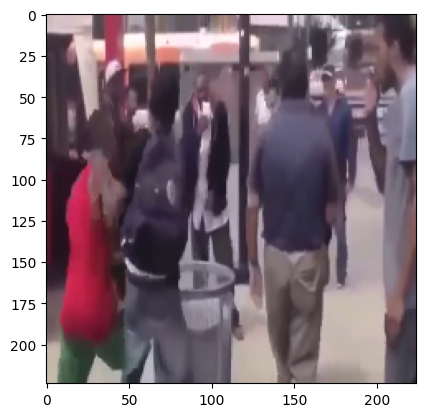

In [9]:
plt.imshow(frames[3])

In [10]:
frames[0].shape

(224, 224, 3)

In [11]:
def convFeaatureImage(frames):
    conv_features=model.predict(np.array(frames))
    return np.array(conv_features)

In [12]:
img_features = convFeaatureImage(frames)

5/5 [==============================] - 11s 2s/step


In [13]:
img_features.shape

(153, 25088)

# **2. Generación del dataset de entrenamiento "inducción al error"**

In [14]:
import glob

In [15]:
paths=[
    "C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/Rviolencia/Real Life Violence Dataset/NonViolence/", 
    "C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/Rviolencia/Real Life Violence Dataset/Violence/"
]

In [79]:
def resize_zeros(img_features, maxFrames):
    rows, col = img_features.shape
    if rows > maxFrames:
        # Si hay más frames de los permitidos, recortar el exceso
        return img_features[:maxFrames, :]
    else:
        # Si hay menos frames, rellenar con ceros
        zeroMatrix = np.zeros((maxFrames - rows, col))
        return np.concatenate((img_features, zeroMatrix), axis=0)


In [17]:
resize_zeros(img_features,180).shape

(180, 25088)

In [18]:
from tqdm import tqdm

In [17]:
"""
data=[]
#sizes=[]
maxFrames=190
for label,path in enumerate(paths):
    for file in tqdm(glob.glob(path+'*.mp4')):
        frames=readVideo(file)
        #sizes.append(len(frames))
        if len(frames)<maxFrames:
            img_features=convFeaatureImage(frames)
            data.append([label,file,resize_zeros(img_features,maxFrames)])
"""
        

In [19]:
maxFrames=190

In [19]:
#plt.hist(sizes,1000,range=[0,200])

# **3. Escribir TFrecords**

In [20]:
import random 
import glob

random.seed(0)

In [21]:
label_videoPath=[]
for label,path in enumerate(paths):
    for file in glob.glob(path+'*.mp4'):
        if random.random()<=0.3:
            label_videoPath.append((label,file))

In [22]:
random.shuffle(label_videoPath)

In [23]:
label_videoPath[0]

(1,
 'C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/Rviolencia/Real Life Violence Dataset/Violence\\V_913.mp4')

In [24]:
eval_files=[file for label,file in label_videoPath[int(0.9*len(label_videoPath))+1::]]
test_files=[file for label,file in label_videoPath[int(0.8*len(label_videoPath))+1:int(0.9*len(label_videoPath))]]

In [26]:
test_files

['C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/Rviolencia/Real Life Violence Dataset/Violence\\V_932.mp4',
 'C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/Rviolencia/Real Life Violence Dataset/NonViolence\\NV_294.mp4',
 'C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/Rviolencia/Real Life Violence Dataset/NonViolence\\NV_374.mp4',
 'C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/Rviolencia/Real Life Violence Dataset/Violence\\V_41.mp4',
 'C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/Rviolencia/Real Life Violence Dataset/Violence\\V_510.mp4',
 'C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/Rviolencia/Real Life Violence Dataset/NonViolence\\NV_810.mp4',
 'C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/Rviolencia/Real Life Violence Dataset/NonViolence\\NV_235.mp4'

In [27]:
print(len(eval_files),len(test_files))

56 55


In [28]:
def createTfExample(img_feature,label):
    sample={ 'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[img_features.shape[0]])),
             'width':  tf.train.Feature(int64_list=tf.train.Int64List(value=[img_features.shape[1]])),
             'image':  tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_features.tobytes()])),
             'label':  tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }
    
    return tf.train.Example(features=tf.train.Features(feature=sample))

In [29]:
train_writer=tf.io.TFRecordWriter('train.record')
eval_writer=tf.io.TFRecordWriter('eval.record')
test_writer=tf.io.TFRecordWriter('test.record')
for label, file in tqdm(label_videoPath):
    frames=readVideo(file)
    if len(frames)<maxFrames:
        img_features=convFeaatureImage(frames)
        img_features=resize_zeros(img_features,maxFrames)
        example=createTfExample(img_features,label)
        if file in eval_files:
            eval_writer.write(example.SerializeToString())
        elif file in test_files:
            test_writer.write(example.SerializeToString())
        else:
            train_writer.write(example.SerializeToString())
train_writer.close()
eval_writer.close()
test_writer.close()

  0%|          | 0/564 [00:00<?, ?it/s]

5/5 [==============================] - 9s 2s/step


  0%|          | 1/564 [00:09<1:28:01,  9.38s/it]

5/5 [==============================] - 10s 2s/step


  0%|          | 2/564 [00:19<1:33:23,  9.97s/it]

5/5 [==============================] - 11s 2s/step


  1%|          | 3/564 [00:30<1:37:51, 10.47s/it]

4/4 [==============================] - 7s 2s/step


  1%|          | 4/564 [00:37<1:23:47,  8.98s/it]

6/6 [==============================] - 11s 2s/step


  1%|          | 5/564 [00:48<1:30:12,  9.68s/it]

5/5 [==============================] - 8s 2s/step


  1%|          | 6/564 [00:56<1:25:42,  9.22s/it]

5/5 [==============================] - 8s 2s/step


  1%|          | 7/564 [01:05<1:24:19,  9.08s/it]

5/5 [==============================] - 8s 1s/step


  1%|▏         | 8/564 [01:13<1:21:08,  8.76s/it]

4/4 [==============================] - 9s 2s/step


  2%|▏         | 9/564 [01:22<1:21:22,  8.80s/it]

5/5 [==============================] - 12s 2s/step


  2%|▏         | 10/564 [01:35<1:31:55,  9.96s/it]

6/6 [==============================] - 14s 2s/step


  2%|▏         | 11/564 [01:48<1:42:51, 11.16s/it]

4/4 [==============================] - 10s 3s/step


  2%|▏         | 12/564 [01:59<1:40:49, 10.96s/it]

4/4 [==============================] - 10s 3s/step


  2%|▏         | 13/564 [02:10<1:39:40, 10.85s/it]

4/4 [==============================] - 11s 3s/step


  2%|▏         | 14/564 [02:21<1:40:34, 10.97s/it]

5/5 [==============================] - 13s 3s/step


  3%|▎         | 15/564 [02:35<1:47:58, 11.80s/it]

4/4 [==============================] - 10s 3s/step


  3%|▎         | 16/564 [02:45<1:44:07, 11.40s/it]

4/4 [==============================] - 9s 2s/step


  3%|▎         | 17/564 [02:54<1:38:24, 10.79s/it]

5/5 [==============================] - 13s 3s/step


  3%|▎         | 18/564 [03:08<1:44:42, 11.51s/it]

6/6 [==============================] - 14s 2s/step


  3%|▎         | 19/564 [03:21<1:51:01, 12.22s/it]

4/4 [==============================] - 10s 3s/step


  4%|▎         | 20/564 [03:32<1:46:38, 11.76s/it]

5/5 [==============================] - 12s 2s/step


  4%|▎         | 21/564 [03:44<1:47:55, 11.93s/it]

6/6 [==============================] - 15s 3s/step


  4%|▍         | 22/564 [04:00<1:57:58, 13.06s/it]

4/4 [==============================] - 10s 2s/step


  4%|▍         | 23/564 [04:10<1:48:46, 12.06s/it]

4/4 [==============================] - 10s 2s/step


  4%|▍         | 24/564 [04:21<1:45:17, 11.70s/it]

6/6 [==============================] - 15s 3s/step


  4%|▍         | 25/564 [04:36<1:55:30, 12.86s/it]

5/5 [==============================] - 13s 2s/step


  5%|▍         | 26/564 [04:49<1:55:41, 12.90s/it]

4/4 [==============================] - 10s 3s/step


  5%|▍         | 27/564 [05:00<1:49:13, 12.20s/it]

5/5 [==============================] - 13s 3s/step


  5%|▍         | 28/564 [05:13<1:51:14, 12.45s/it]

5/5 [==============================] - 12s 2s/step


  5%|▌         | 29/564 [05:25<1:50:40, 12.41s/it]

5/5 [==============================] - 12s 2s/step


  5%|▌         | 30/564 [05:38<1:51:05, 12.48s/it]

2/2 [==============================] - 5s 2s/step


  5%|▌         | 31/564 [05:43<1:30:45, 10.22s/it]

2/2 [==============================] - 5s 2s/step


  6%|▌         | 32/564 [05:48<1:16:37,  8.64s/it]

5/5 [==============================] - 12s 2s/step


  6%|▌         | 33/564 [06:00<1:26:51,  9.81s/it]

4/4 [==============================] - 10s 2s/step


  6%|▌         | 34/564 [06:10<1:27:32,  9.91s/it]

5/5 [==============================] - 13s 3s/step


  6%|▌         | 35/564 [06:24<1:36:36, 10.96s/it]

4/4 [==============================] - 10s 2s/step


  6%|▋         | 36/564 [06:34<1:35:29, 10.85s/it]

5/5 [==============================] - 13s 3s/step


  7%|▋         | 37/564 [06:48<1:42:03, 11.62s/it]

5/5 [==============================] - 13s 2s/step


  7%|▋         | 38/564 [07:01<1:45:33, 12.04s/it]

4/4 [==============================] - 10s 2s/step


  7%|▋         | 39/564 [07:11<1:40:42, 11.51s/it]

4/4 [==============================] - 10s 2s/step


  7%|▋         | 40/564 [07:21<1:37:04, 11.12s/it]

4/4 [==============================] - 11s 3s/step


  7%|▋         | 41/564 [07:32<1:36:50, 11.11s/it]

4/4 [==============================] - 10s 2s/step


  7%|▋         | 42/564 [07:43<1:34:20, 10.84s/it]

4/4 [==============================] - 11s 3s/step


  8%|▊         | 43/564 [07:54<1:35:12, 10.96s/it]

4/4 [==============================] - 9s 2s/step


  8%|▊         | 44/564 [08:04<1:31:32, 10.56s/it]

3/3 [==============================] - 7s 2s/step


  8%|▊         | 45/564 [08:11<1:22:16,  9.51s/it]

4/4 [==============================] - 8s 2s/step


  8%|▊         | 46/564 [08:19<1:18:19,  9.07s/it]

5/5 [==============================] - 10s 2s/step


  8%|▊         | 47/564 [08:29<1:21:52,  9.50s/it]

4/4 [==============================] - 8s 2s/step


  9%|▊         | 48/564 [08:38<1:19:59,  9.30s/it]

4/4 [==============================] - 8s 2s/step


  9%|▉         | 50/564 [08:47<55:46,  6.51s/it]  

5/5 [==============================] - 9s 2s/step


  9%|▉         | 51/564 [08:56<1:02:08,  7.27s/it]

6/6 [==============================] - 11s 2s/step


  9%|▉         | 52/564 [09:08<1:13:19,  8.59s/it]

4/4 [==============================] - 8s 2s/step


  9%|▉         | 53/564 [09:16<1:11:47,  8.43s/it]

4/4 [==============================] - 8s 2s/step


 10%|▉         | 54/564 [09:24<1:11:47,  8.45s/it]

5/5 [==============================] - 10s 2s/step


 10%|▉         | 55/564 [09:35<1:17:14,  9.11s/it]

4/4 [==============================] - 8s 2s/step


 10%|▉         | 56/564 [09:44<1:15:44,  8.95s/it]

4/4 [==============================] - 7s 2s/step


 10%|█         | 57/564 [09:51<1:12:16,  8.55s/it]

4/4 [==============================] - 8s 2s/step


 10%|█         | 58/564 [09:59<1:10:49,  8.40s/it]

4/4 [==============================] - 8s 2s/step


 10%|█         | 59/564 [10:08<1:11:17,  8.47s/it]

4/4 [==============================] - 8s 2s/step


 11%|█         | 60/564 [10:16<1:11:18,  8.49s/it]

6/6 [==============================] - 13s 2s/step


 11%|█         | 61/564 [10:29<1:21:45,  9.75s/it]

4/4 [==============================] - 8s 2s/step


 11%|█         | 62/564 [10:38<1:18:33,  9.39s/it]

4/4 [==============================] - 8s 2s/step


 11%|█         | 63/564 [10:46<1:16:22,  9.15s/it]

5/5 [==============================] - 9s 2s/step


 11%|█▏        | 64/564 [10:55<1:16:25,  9.17s/it]

5/5 [==============================] - 10s 2s/step


 12%|█▏        | 65/564 [11:05<1:17:55,  9.37s/it]

4/4 [==============================] - 7s 2s/step


 12%|█▏        | 66/564 [11:13<1:13:34,  8.86s/it]

5/5 [==============================] - 10s 2s/step


 12%|█▏        | 67/564 [11:23<1:15:44,  9.14s/it]

4/4 [==============================] - 8s 2s/step


 12%|█▏        | 68/564 [11:31<1:12:37,  8.78s/it]

4/4 [==============================] - 8s 2s/step


 12%|█▏        | 69/564 [11:39<1:11:42,  8.69s/it]

5/5 [==============================] - 10s 2s/step


 12%|█▏        | 70/564 [11:49<1:15:28,  9.17s/it]

4/4 [==============================] - 9s 2s/step


 13%|█▎        | 71/564 [11:58<1:15:00,  9.13s/it]

5/5 [==============================] - 10s 2s/step


 13%|█▎        | 72/564 [12:09<1:17:54,  9.50s/it]

4/4 [==============================] - 10s 2s/step


 13%|█▎        | 73/564 [12:19<1:19:49,  9.76s/it]

4/4 [==============================] - 11s 3s/step


 13%|█▎        | 74/564 [12:30<1:22:38, 10.12s/it]

5/5 [==============================] - 11s 2s/step


 13%|█▎        | 75/564 [12:42<1:26:29, 10.61s/it]

5/5 [==============================] - 12s 2s/step


 13%|█▎        | 76/564 [12:54<1:30:12, 11.09s/it]

5/5 [==============================] - 11s 2s/step


 14%|█▎        | 77/564 [13:06<1:31:42, 11.30s/it]

5/5 [==============================] - 13s 2s/step


 14%|█▍        | 78/564 [13:19<1:35:35, 11.80s/it]

4/4 [==============================] - 10s 2s/step


 14%|█▍        | 79/564 [13:29<1:31:22, 11.30s/it]

2/2 [==============================] - 5s 2s/step


 14%|█▍        | 80/564 [13:34<1:15:47,  9.40s/it]

4/4 [==============================] - 11s 3s/step


 14%|█▍        | 81/564 [13:45<1:19:39,  9.90s/it]

6/6 [==============================] - 16s 3s/step


 15%|█▍        | 82/564 [14:01<1:34:22, 11.75s/it]

6/6 [==============================] - 15s 2s/step


 15%|█▍        | 83/564 [14:17<1:43:29, 12.91s/it]

4/4 [==============================] - 9s 2s/step


 15%|█▍        | 84/564 [14:26<1:34:17, 11.79s/it]

5/5 [==============================] - 13s 3s/step


 15%|█▌        | 85/564 [14:39<1:37:45, 12.24s/it]

4/4 [==============================] - 10s 2s/step


 15%|█▌        | 86/564 [14:49<1:32:27, 11.61s/it]

6/6 [==============================] - 14s 2s/step


 15%|█▌        | 87/564 [15:04<1:39:12, 12.48s/it]

4/4 [==============================] - 10s 3s/step


 16%|█▌        | 88/564 [15:14<1:34:33, 11.92s/it]

6/6 [==============================] - 15s 3s/step


 16%|█▌        | 89/564 [15:30<1:42:57, 13.01s/it]

2/2 [==============================] - 5s 2s/step


 16%|█▌        | 90/564 [15:35<1:23:26, 10.56s/it]

6/6 [==============================] - 14s 2s/step


 16%|█▌        | 91/564 [15:49<1:31:27, 11.60s/it]

5/5 [==============================] - 12s 2s/step


 16%|█▋        | 92/564 [16:02<1:34:22, 12.00s/it]

4/4 [==============================] - 9s 2s/step


 16%|█▋        | 93/564 [16:11<1:28:30, 11.27s/it]

3/3 [==============================] - 8s 2s/step


 17%|█▋        | 94/564 [16:19<1:20:10, 10.24s/it]

5/5 [==============================] - 11s 2s/step


 17%|█▋        | 95/564 [16:31<1:23:49, 10.72s/it]

5/5 [==============================] - 12s 2s/step


 17%|█▋        | 96/564 [16:43<1:27:17, 11.19s/it]

5/5 [==============================] - 12s 2s/step


 17%|█▋        | 97/564 [16:56<1:29:59, 11.56s/it]

5/5 [==============================] - 12s 2s/step


 17%|█▋        | 98/564 [17:08<1:31:56, 11.84s/it]

5/5 [==============================] - 13s 2s/step


 18%|█▊        | 99/564 [17:22<1:35:16, 12.29s/it]

4/4 [==============================] - 10s 2s/step


 18%|█▊        | 100/564 [17:33<1:33:14, 12.06s/it]

5/5 [==============================] - 12s 2s/step


 18%|█▊        | 101/564 [17:46<1:34:48, 12.29s/it]

5/5 [==============================] - 13s 2s/step


 18%|█▊        | 102/564 [17:59<1:36:04, 12.48s/it]

5/5 [==============================] - 12s 2s/step


 18%|█▊        | 103/564 [18:12<1:36:49, 12.60s/it]

5/5 [==============================] - 13s 3s/step


 18%|█▊        | 104/564 [18:25<1:37:51, 12.76s/it]

4/4 [==============================] - 10s 2s/step


 19%|█▊        | 105/564 [18:35<1:30:46, 11.87s/it]

3/3 [==============================] - 8s 2s/step


 19%|█▉        | 106/564 [18:42<1:21:15, 10.65s/it]

5/5 [==============================] - 12s 2s/step


 19%|█▉        | 107/564 [18:55<1:24:48, 11.14s/it]

6/6 [==============================] - 14s 2s/step


 19%|█▉        | 108/564 [19:09<1:32:11, 12.13s/it]

4/4 [==============================] - 8s 2s/step


 19%|█▉        | 109/564 [19:18<1:24:09, 11.10s/it]

4/4 [==============================] - 9s 2s/step


 20%|█▉        | 110/564 [19:28<1:20:48, 10.68s/it]

5/5 [==============================] - 11s 2s/step


 20%|█▉        | 111/564 [19:39<1:22:19, 10.90s/it]

5/5 [==============================] - 12s 2s/step


 20%|█▉        | 112/564 [19:52<1:27:02, 11.55s/it]

6/6 [==============================] - 13s 2s/step


 20%|██        | 113/564 [20:06<1:32:59, 12.37s/it]

5/5 [==============================] - 12s 2s/step


 20%|██        | 114/564 [20:19<1:32:43, 12.36s/it]

5/5 [==============================] - 12s 2s/step


 20%|██        | 115/564 [20:31<1:32:31, 12.36s/it]

4/4 [==============================] - 7s 2s/step


 21%|██        | 116/564 [20:39<1:21:24, 10.90s/it]

5/5 [==============================] - 8s 2s/step


 21%|██        | 117/564 [20:47<1:16:17, 10.24s/it]

4/4 [==============================] - 7s 2s/step


 21%|██        | 118/564 [20:54<1:08:42,  9.24s/it]

5/5 [==============================] - 9s 2s/step


 21%|██        | 119/564 [21:03<1:07:17,  9.07s/it]

5/5 [==============================] - 9s 2s/step


 21%|██▏       | 121/564 [21:12<51:45,  7.01s/it]  

2/2 [==============================] - 3s 1s/step


 22%|██▏       | 122/564 [21:15<44:57,  6.10s/it]

5/5 [==============================] - 8s 2s/step


 22%|██▏       | 123/564 [21:24<49:42,  6.76s/it]

4/4 [==============================] - 7s 2s/step


 22%|██▏       | 124/564 [21:31<50:23,  6.87s/it]

6/6 [==============================] - 10s 2s/step


 22%|██▏       | 125/564 [21:42<57:21,  7.84s/it]

2/2 [==============================] - 3s 1s/step


 22%|██▏       | 126/564 [21:45<47:58,  6.57s/it]

5/5 [==============================] - 9s 2s/step


 23%|██▎       | 127/564 [21:54<52:25,  7.20s/it]

5/5 [==============================] - 8s 2s/step


 23%|██▎       | 128/564 [22:02<54:47,  7.54s/it]

4/4 [==============================] - 8s 2s/step


 23%|██▎       | 129/564 [22:10<55:20,  7.63s/it]

5/5 [==============================] - 10s 2s/step


 23%|██▎       | 130/564 [22:20<1:00:14,  8.33s/it]

4/4 [==============================] - 7s 2s/step


 23%|██▎       | 131/564 [22:28<58:41,  8.13s/it]  

5/5 [==============================] - 10s 2s/step


 23%|██▎       | 132/564 [22:38<1:02:46,  8.72s/it]

4/4 [==============================] - 9s 2s/step


 24%|██▎       | 133/564 [22:46<1:02:37,  8.72s/it]

5/5 [==============================] - 10s 2s/step


 24%|██▍       | 134/564 [22:57<1:05:52,  9.19s/it]

4/4 [==============================] - 8s 2s/step


 24%|██▍       | 135/564 [23:05<1:04:38,  9.04s/it]

4/4 [==============================] - 8s 2s/step


 24%|██▍       | 136/564 [23:14<1:03:31,  8.90s/it]

5/5 [==============================] - 10s 2s/step


 24%|██▍       | 137/564 [23:25<1:07:09,  9.44s/it]

5/5 [==============================] - 10s 2s/step


 24%|██▍       | 138/564 [23:35<1:08:43,  9.68s/it]

4/4 [==============================] - 9s 2s/step


 25%|██▍       | 139/564 [23:44<1:07:32,  9.53s/it]

2/2 [==============================] - 5s 2s/step


 25%|██▍       | 140/564 [23:49<57:13,  8.10s/it]  

4/4 [==============================] - 11s 3s/step


 25%|██▌       | 141/564 [24:00<1:03:36,  9.02s/it]

3/3 [==============================] - 8s 3s/step


 25%|██▌       | 142/564 [24:09<1:02:31,  8.89s/it]

5/5 [==============================] - 11s 2s/step


 25%|██▌       | 143/564 [24:21<1:08:56,  9.83s/it]

4/4 [==============================] - 11s 3s/step


 26%|██▌       | 144/564 [24:32<1:11:14, 10.18s/it]

4/4 [==============================] - 10s 2s/step


 26%|██▌       | 145/564 [24:42<1:11:20, 10.22s/it]

5/5 [==============================] - 13s 2s/step


 26%|██▌       | 146/564 [24:55<1:16:41, 11.01s/it]

5/5 [==============================] - 10s 2s/step


 26%|██▌       | 147/564 [25:05<1:14:14, 10.68s/it]

4/4 [==============================] - 8s 2s/step


 26%|██▌       | 148/564 [25:13<1:08:12,  9.84s/it]

5/5 [==============================] - 10s 2s/step


 26%|██▋       | 149/564 [25:23<1:09:35, 10.06s/it]

6/6 [==============================] - 13s 2s/step


 27%|██▋       | 150/564 [25:36<1:15:04, 10.88s/it]

5/5 [==============================] - 10s 2s/step


 27%|██▋       | 151/564 [25:46<1:13:15, 10.64s/it]

4/4 [==============================] - 8s 2s/step


 27%|██▋       | 152/564 [25:54<1:08:30,  9.98s/it]

5/5 [==============================] - 11s 2s/step


 27%|██▋       | 153/564 [26:05<1:09:47, 10.19s/it]

5/5 [==============================] - 9s 2s/step


 27%|██▋       | 154/564 [26:14<1:07:38,  9.90s/it]

4/4 [==============================] - 7s 2s/step


 27%|██▋       | 155/564 [26:22<1:02:56,  9.23s/it]

4/4 [==============================] - 8s 2s/step


 28%|██▊       | 156/564 [26:31<1:01:29,  9.04s/it]

4/4 [==============================] - 8s 2s/step


 28%|██▊       | 157/564 [26:39<59:05,  8.71s/it]  

5/5 [==============================] - 10s 2s/step


 28%|██▊       | 158/564 [26:49<1:03:12,  9.34s/it]

4/4 [==============================] - 8s 2s/step


 28%|██▊       | 159/564 [26:58<1:01:02,  9.04s/it]

2/2 [==============================] - 4s 2s/step


 28%|██▊       | 160/564 [27:02<50:23,  7.48s/it]  

5/5 [==============================] - 9s 2s/step


 29%|██▊       | 161/564 [27:11<53:35,  7.98s/it]

6/6 [==============================] - 12s 2s/step


 29%|██▊       | 162/564 [27:23<1:02:23,  9.31s/it]

5/5 [==============================] - 10s 2s/step


 29%|██▉       | 163/564 [27:34<1:04:46,  9.69s/it]

4/4 [==============================] - 8s 2s/step


 29%|██▉       | 164/564 [27:42<1:01:50,  9.28s/it]

2/2 [==============================] - 4s 2s/step


 29%|██▉       | 165/564 [27:46<50:59,  7.67s/it]  

5/5 [==============================] - 9s 2s/step


 29%|██▉       | 166/564 [27:55<54:15,  8.18s/it]

5/5 [==============================] - 10s 2s/step


 30%|██▉       | 167/564 [28:05<57:33,  8.70s/it]

5/5 [==============================] - 10s 2s/step


 30%|██▉       | 168/564 [28:15<1:00:27,  9.16s/it]

4/4 [==============================] - 8s 2s/step


 30%|██▉       | 169/564 [28:24<59:19,  9.01s/it]  

4/4 [==============================] - 9s 2s/step


 30%|███       | 170/564 [28:33<58:32,  8.91s/it]

4/4 [==============================] - 7s 2s/step


 30%|███       | 171/564 [28:41<56:10,  8.58s/it]

6/6 [==============================] - 13s 2s/step


 30%|███       | 172/564 [28:53<1:04:11,  9.82s/it]

2/2 [==============================] - 4s 2s/step


 31%|███       | 173/564 [28:57<52:55,  8.12s/it]  

4/4 [==============================] - 9s 2s/step


 31%|███       | 174/564 [29:07<55:38,  8.56s/it]

4/4 [==============================] - 8s 2s/step


 31%|███       | 175/564 [29:16<55:33,  8.57s/it]

4/4 [==============================] - 8s 2s/step


 31%|███       | 176/564 [29:24<55:05,  8.52s/it]

4/4 [==============================] - 8s 2s/step


 31%|███▏      | 177/564 [29:32<53:37,  8.31s/it]

4/4 [==============================] - 8s 2s/step


 32%|███▏      | 178/564 [29:40<52:33,  8.17s/it]

4/4 [==============================] - 8s 2s/step


 32%|███▏      | 179/564 [29:48<53:21,  8.32s/it]

4/4 [==============================] - 8s 2s/step


 32%|███▏      | 180/564 [29:57<54:10,  8.46s/it]

6/6 [==============================] - 12s 2s/step


 32%|███▏      | 181/564 [30:10<1:02:09,  9.74s/it]

4/4 [==============================] - 9s 2s/step


 32%|███▏      | 182/564 [30:19<1:01:24,  9.64s/it]

4/4 [==============================] - 10s 2s/step


 32%|███▏      | 183/564 [30:30<1:02:22,  9.82s/it]

4/4 [==============================] - 9s 2s/step


 33%|███▎      | 184/564 [30:39<1:01:57,  9.78s/it]

4/4 [==============================] - 11s 3s/step


 33%|███▎      | 185/564 [30:50<1:03:51, 10.11s/it]

5/5 [==============================] - 12s 2s/step


 33%|███▎      | 186/564 [31:02<1:07:24, 10.70s/it]

5/5 [==============================] - 11s 2s/step


 33%|███▎      | 187/564 [31:14<1:08:54, 10.97s/it]

2/2 [==============================] - 5s 2s/step


 33%|███▎      | 188/564 [31:19<57:09,  9.12s/it]  

5/5 [==============================] - 13s 3s/step


 34%|███▎      | 189/564 [31:32<1:04:39, 10.35s/it]

4/4 [==============================] - 9s 2s/step


 34%|███▎      | 190/564 [31:41<1:01:46,  9.91s/it]

5/5 [==============================] - 8s 2s/step


 34%|███▍      | 191/564 [31:50<59:45,  9.61s/it]  

4/4 [==============================] - 7s 2s/step


 34%|███▍      | 192/564 [31:57<55:37,  8.97s/it]

3/3 [==============================] - 5s 2s/step


 34%|███▍      | 193/564 [32:03<48:55,  7.91s/it]

4/4 [==============================] - 7s 2s/step


 34%|███▍      | 194/564 [32:10<48:46,  7.91s/it]

5/5 [==============================] - 9s 2s/step


 35%|███▍      | 195/564 [32:20<52:04,  8.47s/it]

6/6 [==============================] - 11s 2s/step


 35%|███▍      | 196/564 [32:31<56:23,  9.19s/it]

6/6 [==============================] - 11s 2s/step


 35%|███▍      | 197/564 [32:43<1:00:26,  9.88s/it]

4/4 [==============================] - 7s 2s/step


 35%|███▌      | 198/564 [32:50<55:28,  9.09s/it]  

5/5 [==============================] - 11s 2s/step


 35%|███▌      | 199/564 [33:01<59:11,  9.73s/it]

6/6 [==============================] - 15s 2s/step


 35%|███▌      | 200/564 [33:17<1:09:57, 11.53s/it]

4/4 [==============================] - 11s 3s/step


 36%|███▌      | 201/564 [33:28<1:08:54, 11.39s/it]

4/4 [==============================] - 9s 2s/step


 36%|███▌      | 202/564 [33:38<1:06:22, 11.00s/it]

6/6 [==============================] - 15s 3s/step


 36%|███▌      | 203/564 [33:53<1:14:20, 12.36s/it]

2/2 [==============================] - 5s 2s/step


 36%|███▌      | 204/564 [33:58<1:00:38, 10.11s/it]

2/2 [==============================] - 5s 2s/step


 36%|███▋      | 205/564 [34:03<51:07,  8.54s/it]  

5/5 [==============================] - 11s 2s/step


 37%|███▋      | 206/564 [34:15<57:29,  9.64s/it]

4/4 [==============================] - 10s 2s/step


 37%|███▋      | 207/564 [34:25<58:00,  9.75s/it]

5/5 [==============================] - 12s 2s/step


 37%|███▋      | 208/564 [34:38<1:02:18, 10.50s/it]

5/5 [==============================] - 12s 2s/step


 37%|███▋      | 209/564 [34:50<1:05:40, 11.10s/it]

5/5 [==============================] - 11s 2s/step


 37%|███▋      | 210/564 [35:02<1:06:11, 11.22s/it]

6/6 [==============================] - 14s 2s/step


 37%|███▋      | 211/564 [35:16<1:11:22, 12.13s/it]

5/5 [==============================] - 12s 2s/step


 38%|███▊      | 212/564 [35:28<1:11:43, 12.22s/it]

4/4 [==============================] - 9s 2s/step


 38%|███▊      | 213/564 [35:37<1:05:54, 11.27s/it]

4/4 [==============================] - 9s 2s/step


 38%|███▊      | 214/564 [35:47<1:02:58, 10.79s/it]

2/2 [==============================] - 5s 2s/step


 38%|███▊      | 215/564 [35:52<52:13,  8.98s/it]  

4/4 [==============================] - 8s 2s/step


 38%|███▊      | 216/564 [36:00<51:15,  8.84s/it]

3/3 [==============================] - 7s 2s/step


 38%|███▊      | 217/564 [36:09<50:46,  8.78s/it]

5/5 [==============================] - 12s 2s/step


 39%|███▊      | 218/564 [36:22<57:26,  9.96s/it]

5/5 [==============================] - 13s 2s/step


 39%|███▉      | 219/564 [36:34<1:02:06, 10.80s/it]

5/5 [==============================] - 12s 2s/step


 39%|███▉      | 220/564 [36:47<1:04:42, 11.29s/it]

5/5 [==============================] - 13s 2s/step


 39%|███▉      | 221/564 [37:00<1:07:15, 11.76s/it]

5/5 [==============================] - 12s 2s/step


 39%|███▉      | 222/564 [37:12<1:08:43, 12.06s/it]

4/4 [==============================] - 10s 2s/step


 40%|███▉      | 223/564 [37:22<1:04:45, 11.39s/it]

4/4 [==============================] - 9s 2s/step


 40%|███▉      | 224/564 [37:31<1:00:32, 10.68s/it]

4/4 [==============================] - 10s 2s/step


 40%|███▉      | 225/564 [37:42<1:00:00, 10.62s/it]

5/5 [==============================] - 12s 2s/step


 40%|████      | 226/564 [37:54<1:02:45, 11.14s/it]

5/5 [==============================] - 13s 2s/step


 40%|████      | 227/564 [38:07<1:05:18, 11.63s/it]

4/4 [==============================] - 10s 2s/step


 40%|████      | 228/564 [38:18<1:03:24, 11.32s/it]

5/5 [==============================] - 13s 3s/step


 41%|████      | 229/564 [38:31<1:06:28, 11.91s/it]

4/4 [==============================] - 11s 3s/step


 41%|████      | 230/564 [38:42<1:05:12, 11.71s/it]

4/4 [==============================] - 10s 2s/step


 41%|████      | 231/564 [38:52<1:02:30, 11.26s/it]

5/5 [==============================] - 13s 2s/step


 41%|████      | 232/564 [39:05<1:04:56, 11.74s/it]

4/4 [==============================] - 10s 2s/step


 41%|████▏     | 233/564 [39:15<1:01:33, 11.16s/it]

5/5 [==============================] - 12s 2s/step


 41%|████▏     | 234/564 [39:28<1:03:57, 11.63s/it]

2/2 [==============================] - 5s 2s/step


 42%|████▏     | 235/564 [39:33<52:48,  9.63s/it]  

5/5 [==============================] - 11s 2s/step


 42%|████▏     | 236/564 [39:45<56:17, 10.30s/it]

4/4 [==============================] - 11s 3s/step


 42%|████▏     | 237/564 [39:55<57:11, 10.49s/it]

5/5 [==============================] - 13s 2s/step


 42%|████▏     | 238/564 [40:08<1:00:48, 11.19s/it]

6/6 [==============================] - 16s 3s/step


 42%|████▏     | 239/564 [40:25<1:08:57, 12.73s/it]

4/4 [==============================] - 10s 2s/step


 43%|████▎     | 240/564 [40:35<1:04:56, 12.03s/it]

5/5 [==============================] - 13s 3s/step


 43%|████▎     | 241/564 [40:48<1:06:34, 12.37s/it]

4/4 [==============================] - 11s 3s/step


 43%|████▎     | 242/564 [40:59<1:04:23, 12.00s/it]

4/4 [==============================] - 11s 3s/step


 43%|████▎     | 243/564 [41:10<1:02:32, 11.69s/it]

4/4 [==============================] - 10s 2s/step


 43%|████▎     | 244/564 [41:21<1:00:05, 11.27s/it]

5/5 [==============================] - 13s 3s/step


 43%|████▎     | 245/564 [41:34<1:03:40, 11.98s/it]

5/5 [==============================] - 13s 2s/step


 44%|████▎     | 246/564 [41:47<1:04:55, 12.25s/it]

4/4 [==============================] - 9s 2s/step


 44%|████▍     | 247/564 [41:56<59:45, 11.31s/it]  

4/4 [==============================] - 10s 2s/step


 44%|████▍     | 248/564 [42:06<57:53, 10.99s/it]

4/4 [==============================] - 10s 2s/step


 44%|████▍     | 249/564 [42:17<56:28, 10.76s/it]

6/6 [==============================] - 15s 3s/step


 44%|████▍     | 250/564 [42:32<1:04:05, 12.25s/it]

5/5 [==============================] - 13s 2s/step


 45%|████▍     | 251/564 [42:45<1:04:44, 12.41s/it]

2/2 [==============================] - 5s 2s/step


 45%|████▍     | 252/564 [42:50<53:01, 10.20s/it]  

4/4 [==============================] - 10s 2s/step


 45%|████▍     | 253/564 [43:01<53:03, 10.24s/it]

4/4 [==============================] - 10s 3s/step


 45%|████▌     | 254/564 [43:11<53:23, 10.34s/it]

4/4 [==============================] - 11s 3s/step


 45%|████▌     | 255/564 [43:22<54:36, 10.60s/it]

6/6 [==============================] - 15s 2s/step


 45%|████▌     | 256/564 [43:38<1:02:03, 12.09s/it]

4/4 [==============================] - 10s 2s/step


 46%|████▌     | 257/564 [43:48<58:46, 11.49s/it]  

4/4 [==============================] - 9s 2s/step


 46%|████▌     | 258/564 [43:58<55:38, 10.91s/it]

6/6 [==============================] - 16s 3s/step


 46%|████▌     | 259/564 [44:14<1:03:32, 12.50s/it]

4/4 [==============================] - 9s 2s/step


 46%|████▌     | 260/564 [44:24<59:14, 11.69s/it]  

5/5 [==============================] - 11s 2s/step


 46%|████▋     | 261/564 [44:35<58:39, 11.62s/it]

5/5 [==============================] - 11s 2s/step


 46%|████▋     | 262/564 [44:46<57:43, 11.47s/it]

5/5 [==============================] - 12s 2s/step


 47%|████▋     | 263/564 [44:58<58:46, 11.72s/it]

2/2 [==============================] - 5s 2s/step


 47%|████▋     | 264/564 [45:03<48:14,  9.65s/it]

6/6 [==============================] - 15s 2s/step


 47%|████▋     | 265/564 [45:19<56:55, 11.42s/it]

5/5 [==============================] - 12s 2s/step


 47%|████▋     | 266/564 [45:31<58:03, 11.69s/it]

4/4 [==============================] - 10s 3s/step


 47%|████▋     | 267/564 [45:42<56:20, 11.38s/it]

5/5 [==============================] - 12s 2s/step


 48%|████▊     | 268/564 [45:54<57:51, 11.73s/it]

6/6 [==============================] - 15s 2s/step


 48%|████▊     | 269/564 [46:10<1:03:06, 12.83s/it]

6/6 [==============================] - 15s 3s/step


 48%|████▊     | 270/564 [46:25<1:06:56, 13.66s/it]

4/4 [==============================] - 10s 2s/step


 48%|████▊     | 271/564 [46:36<1:01:55, 12.68s/it]

4/4 [==============================] - 10s 3s/step


 48%|████▊     | 272/564 [46:46<58:37, 12.05s/it]  

5/5 [==============================] - 12s 2s/step


 48%|████▊     | 273/564 [46:58<58:34, 12.08s/it]

4/4 [==============================] - 10s 2s/step


 49%|████▊     | 274/564 [47:08<55:05, 11.40s/it]

6/6 [==============================] - 14s 2s/step


 49%|████▉     | 275/564 [47:23<59:42, 12.40s/it]

5/5 [==============================] - 11s 2s/step


 49%|████▉     | 276/564 [47:35<58:39, 12.22s/it]

5/5 [==============================] - 11s 2s/step


 49%|████▉     | 277/564 [47:46<57:29, 12.02s/it]

4/4 [==============================] - 10s 3s/step


 49%|████▉     | 278/564 [47:57<55:21, 11.61s/it]

5/5 [==============================] - 12s 2s/step


 49%|████▉     | 279/564 [48:09<55:59, 11.79s/it]

6/6 [==============================] - 13s 2s/step


 50%|████▉     | 280/564 [48:23<59:13, 12.51s/it]

4/4 [==============================] - 9s 2s/step


 50%|████▉     | 281/564 [48:33<54:35, 11.57s/it]

5/5 [==============================] - 12s 2s/step


 50%|█████     | 282/564 [48:45<55:32, 11.82s/it]

4/4 [==============================] - 10s 3s/step


 50%|█████     | 283/564 [48:56<53:36, 11.45s/it]

5/5 [==============================] - 13s 2s/step


 50%|█████     | 284/564 [49:09<55:32, 11.90s/it]

4/4 [==============================] - 10s 3s/step


 51%|█████     | 285/564 [49:19<53:28, 11.50s/it]

5/5 [==============================] - 11s 2s/step


 51%|█████     | 286/564 [49:31<53:33, 11.56s/it]

6/6 [==============================] - 14s 2s/step


 51%|█████     | 287/564 [49:45<56:34, 12.25s/it]

5/5 [==============================] - 13s 2s/step


 51%|█████     | 288/564 [49:58<57:04, 12.41s/it]

5/5 [==============================] - 12s 2s/step


 51%|█████     | 289/564 [50:10<57:22, 12.52s/it]

4/4 [==============================] - 10s 2s/step


 51%|█████▏    | 290/564 [50:20<53:36, 11.74s/it]

5/5 [==============================] - 13s 3s/step


 52%|█████▏    | 291/564 [50:34<55:28, 12.19s/it]

6/6 [==============================] - 15s 3s/step


 52%|█████▏    | 292/564 [50:49<1:00:11, 13.28s/it]

5/5 [==============================] - 12s 2s/step


 52%|█████▏    | 293/564 [51:02<58:49, 13.03s/it]  

5/5 [==============================] - 13s 2s/step


 52%|█████▏    | 294/564 [51:15<58:16, 12.95s/it]

4/4 [==============================] - 10s 2s/step


 52%|█████▏    | 295/564 [51:25<54:24, 12.14s/it]

5/5 [==============================] - 13s 3s/step


 52%|█████▏    | 296/564 [51:38<56:10, 12.58s/it]

5/5 [==============================] - 12s 2s/step


 53%|█████▎    | 297/564 [51:51<55:56, 12.57s/it]

6/6 [==============================] - 15s 2s/step


 53%|█████▎    | 298/564 [52:06<59:31, 13.43s/it]

4/4 [==============================] - 11s 3s/step


 53%|█████▎    | 299/564 [52:17<56:07, 12.71s/it]

5/5 [==============================] - 11s 2s/step


 53%|█████▎    | 300/564 [52:29<54:45, 12.44s/it]

5/5 [==============================] - 10s 2s/step


 53%|█████▎    | 301/564 [52:40<52:02, 11.87s/it]

6/6 [==============================] - 12s 2s/step


 54%|█████▎    | 302/564 [52:52<51:50, 11.87s/it]

4/4 [==============================] - 8s 2s/step


 54%|█████▎    | 303/564 [53:00<47:16, 10.87s/it]

6/6 [==============================] - 11s 2s/step


 54%|█████▍    | 304/564 [53:12<48:23, 11.17s/it]

4/4 [==============================] - 8s 2s/step


 54%|█████▍    | 305/564 [53:20<44:35, 10.33s/it]

6/6 [==============================] - 11s 2s/step


 54%|█████▍    | 306/564 [53:32<45:30, 10.58s/it]

4/4 [==============================] - 8s 2s/step


 54%|█████▍    | 307/564 [53:40<42:29,  9.92s/it]

5/5 [==============================] - 10s 2s/step


 55%|█████▍    | 308/564 [53:50<42:47, 10.03s/it]

5/5 [==============================] - 10s 2s/step


 55%|█████▍    | 309/564 [54:00<42:33, 10.01s/it]

5/5 [==============================] - 10s 2s/step


 55%|█████▍    | 310/564 [54:10<42:29, 10.04s/it]

5/5 [==============================] - 9s 2s/step


 55%|█████▌    | 311/564 [54:20<41:19,  9.80s/it]

4/4 [==============================] - 8s 2s/step


 55%|█████▌    | 312/564 [54:28<39:11,  9.33s/it]

4/4 [==============================] - 9s 2s/step


 55%|█████▌    | 313/564 [54:37<38:39,  9.24s/it]

5/5 [==============================] - 12s 2s/step


 56%|█████▌    | 314/564 [54:49<42:27, 10.19s/it]

4/4 [==============================] - 10s 2s/step


 56%|█████▌    | 315/564 [54:59<42:03, 10.14s/it]

5/5 [==============================] - 13s 2s/step


 56%|█████▌    | 316/564 [55:12<45:09, 10.93s/it]

5/5 [==============================] - 13s 3s/step


 56%|█████▋    | 318/564 [55:26<34:26,  8.40s/it]

5/5 [==============================] - 13s 3s/step


 57%|█████▋    | 319/564 [55:40<40:55, 10.02s/it]

4/4 [==============================] - 10s 3s/step


 57%|█████▋    | 320/564 [55:51<41:29, 10.20s/it]

4/4 [==============================] - 10s 2s/step


 57%|█████▋    | 321/564 [56:00<40:45, 10.07s/it]

4/4 [==============================] - 10s 2s/step


 57%|█████▋    | 322/564 [56:10<40:20, 10.00s/it]

4/4 [==============================] - 10s 3s/step


 57%|█████▋    | 323/564 [56:21<40:54, 10.19s/it]

5/5 [==============================] - 12s 2s/step


 57%|█████▋    | 324/564 [56:33<43:14, 10.81s/it]

6/6 [==============================] - 14s 2s/step


 58%|█████▊    | 325/564 [56:48<47:21, 11.89s/it]

5/5 [==============================] - 12s 2s/step


 58%|█████▊    | 327/564 [57:02<35:30,  8.99s/it]

4/4 [==============================] - 10s 3s/step


 58%|█████▊    | 328/564 [57:13<37:02,  9.42s/it]

6/6 [==============================] - 15s 3s/step


 58%|█████▊    | 329/564 [57:28<44:07, 11.27s/it]

4/4 [==============================] - 8s 2s/step


 59%|█████▊    | 330/564 [57:36<40:31, 10.39s/it]

5/5 [==============================] - 11s 2s/step


 59%|█████▊    | 331/564 [57:48<41:39, 10.73s/it]

5/5 [==============================] - 9s 2s/step


 59%|█████▉    | 332/564 [57:58<40:08, 10.38s/it]

4/4 [==============================] - 7s 2s/step


 59%|█████▉    | 333/564 [58:05<36:40,  9.52s/it]

4/4 [==============================] - 8s 2s/step


 59%|█████▉    | 334/564 [58:13<34:27,  8.99s/it]

4/4 [==============================] - 7s 2s/step


 59%|█████▉    | 335/564 [58:21<32:47,  8.59s/it]

5/5 [==============================] - 9s 2s/step


 60%|█████▉    | 336/564 [58:30<34:14,  9.01s/it]

4/4 [==============================] - 8s 2s/step


 60%|█████▉    | 337/564 [58:38<32:35,  8.61s/it]

4/4 [==============================] - 6s 1s/step


 60%|█████▉    | 338/564 [58:45<29:58,  7.96s/it]

4/4 [==============================] - 8s 2s/step


 60%|██████    | 339/564 [58:53<29:49,  7.95s/it]

5/5 [==============================] - 11s 2s/step


 60%|██████    | 340/564 [59:04<33:27,  8.96s/it]

5/5 [==============================] - 12s 2s/step


 60%|██████    | 341/564 [59:16<37:02,  9.97s/it]

5/5 [==============================] - 13s 2s/step


 61%|██████    | 342/564 [59:29<40:09, 10.85s/it]

5/5 [==============================] - 12s 2s/step


 61%|██████    | 343/564 [59:42<41:50, 11.36s/it]

5/5 [==============================] - 12s 2s/step


 61%|██████    | 344/564 [59:54<42:44, 11.66s/it]

5/5 [==============================] - 12s 2s/step


 61%|██████    | 345/564 [1:00:06<42:55, 11.76s/it]

3/3 [==============================] - 6s 2s/step


 61%|██████▏   | 346/564 [1:00:13<37:53, 10.43s/it]

4/4 [==============================] - 10s 3s/step


 62%|██████▏   | 347/564 [1:00:24<37:44, 10.44s/it]

4/4 [==============================] - 9s 2s/step


 62%|██████▏   | 348/564 [1:00:33<36:23, 10.11s/it]

5/5 [==============================] - 13s 2s/step


 62%|██████▏   | 349/564 [1:00:47<39:47, 11.10s/it]

4/4 [==============================] - 10s 3s/step


 62%|██████▏   | 350/564 [1:00:57<38:55, 10.91s/it]

5/5 [==============================] - 12s 2s/step


 62%|██████▏   | 351/564 [1:01:09<40:14, 11.34s/it]

4/4 [==============================] - 10s 3s/step


 63%|██████▎   | 353/564 [1:01:20<27:23,  7.79s/it]

5/5 [==============================] - 11s 2s/step


 63%|██████▎   | 354/564 [1:01:32<31:15,  8.93s/it]

6/6 [==============================] - 15s 3s/step


 63%|██████▎   | 355/564 [1:01:47<38:09, 10.95s/it]

5/5 [==============================] - 12s 2s/step


 63%|██████▎   | 356/564 [1:01:59<39:18, 11.34s/it]

2/2 [==============================] - 5s 2s/step


 63%|██████▎   | 357/564 [1:02:04<32:24,  9.39s/it]

5/5 [==============================] - 12s 2s/step


 63%|██████▎   | 358/564 [1:02:17<35:13, 10.26s/it]

4/4 [==============================] - 10s 3s/step


 64%|██████▎   | 359/564 [1:02:27<35:12, 10.30s/it]

4/4 [==============================] - 10s 2s/step


 64%|██████▍   | 360/564 [1:02:37<34:55, 10.27s/it]

5/5 [==============================] - 12s 2s/step


 64%|██████▍   | 361/564 [1:02:50<36:55, 10.91s/it]

6/6 [==============================] - 14s 2s/step


 64%|██████▍   | 362/564 [1:03:04<40:33, 12.04s/it]

4/4 [==============================] - 10s 2s/step


 64%|██████▍   | 363/564 [1:03:14<38:19, 11.44s/it]

2/2 [==============================] - 4s 2s/step


 65%|██████▍   | 364/564 [1:03:19<31:13,  9.37s/it]

3/3 [==============================] - 7s 2s/step


 65%|██████▍   | 365/564 [1:03:27<29:23,  8.86s/it]

2/2 [==============================] - 4s 2s/step


 65%|██████▍   | 366/564 [1:03:31<25:03,  7.59s/it]

6/6 [==============================] - 15s 2s/step


 65%|██████▌   | 367/564 [1:03:46<32:08,  9.79s/it]

4/4 [==============================] - 10s 2s/step


 65%|██████▌   | 368/564 [1:03:56<32:36,  9.98s/it]

5/5 [==============================] - 12s 2s/step


 65%|██████▌   | 369/564 [1:04:09<34:45, 10.70s/it]

5/5 [==============================] - 11s 2s/step


 66%|██████▌   | 370/564 [1:04:20<34:41, 10.73s/it]

3/3 [==============================] - 8s 3s/step


 66%|██████▌   | 371/564 [1:04:28<31:52,  9.91s/it]

4/4 [==============================] - 10s 2s/step


 66%|██████▌   | 372/564 [1:04:38<31:53,  9.97s/it]

4/4 [==============================] - 10s 2s/step


 66%|██████▌   | 373/564 [1:04:48<32:06, 10.09s/it]

3/3 [==============================] - 7s 2s/step


 66%|██████▋   | 374/564 [1:04:55<29:12,  9.22s/it]

6/6 [==============================] - 14s 2s/step


 66%|██████▋   | 375/564 [1:05:10<33:45, 10.72s/it]

6/6 [==============================] - 15s 2s/step


 67%|██████▋   | 376/564 [1:05:24<37:25, 11.94s/it]

4/4 [==============================] - 9s 2s/step


 67%|██████▋   | 377/564 [1:05:34<34:44, 11.15s/it]

5/5 [==============================] - 12s 2s/step


 67%|██████▋   | 378/564 [1:05:46<36:01, 11.62s/it]

5/5 [==============================] - 11s 2s/step


 67%|██████▋   | 379/564 [1:05:58<36:16, 11.76s/it]

5/5 [==============================] - 12s 2s/step


 67%|██████▋   | 380/564 [1:06:11<36:43, 11.97s/it]

4/4 [==============================] - 10s 2s/step


 68%|██████▊   | 381/564 [1:06:21<35:13, 11.55s/it]

5/5 [==============================] - 11s 2s/step


 68%|██████▊   | 382/564 [1:06:33<34:40, 11.43s/it]

5/5 [==============================] - 11s 2s/step


 68%|██████▊   | 383/564 [1:06:44<34:14, 11.35s/it]

4/4 [==============================] - 9s 2s/step


 68%|██████▊   | 384/564 [1:06:54<32:56, 10.98s/it]

5/5 [==============================] - 14s 3s/step


 68%|██████▊   | 385/564 [1:07:08<35:52, 12.02s/it]

4/4 [==============================] - 11s 3s/step


 68%|██████▊   | 386/564 [1:07:20<34:56, 11.78s/it]

2/2 [==============================] - 5s 2s/step


 69%|██████▊   | 387/564 [1:07:25<29:00,  9.83s/it]

4/4 [==============================] - 11s 3s/step


 69%|██████▉   | 388/564 [1:07:36<30:02, 10.24s/it]

4/4 [==============================] - 10s 3s/step


 69%|██████▉   | 389/564 [1:07:47<30:13, 10.36s/it]

4/4 [==============================] - 10s 2s/step


 69%|██████▉   | 390/564 [1:07:57<30:02, 10.36s/it]

6/6 [==============================] - 15s 3s/step


 69%|██████▉   | 391/564 [1:08:13<34:30, 11.97s/it]

5/5 [==============================] - 11s 2s/step


 70%|██████▉   | 392/564 [1:08:24<34:03, 11.88s/it]

5/5 [==============================] - 13s 3s/step


 70%|██████▉   | 393/564 [1:08:38<35:13, 12.36s/it]

5/5 [==============================] - 13s 2s/step


 70%|██████▉   | 394/564 [1:08:52<36:04, 12.73s/it]

5/5 [==============================] - 12s 2s/step


 70%|███████   | 395/564 [1:09:04<35:39, 12.66s/it]

4/4 [==============================] - 9s 2s/step


 70%|███████   | 396/564 [1:09:13<32:41, 11.68s/it]

5/5 [==============================] - 11s 2s/step


 70%|███████   | 397/564 [1:09:25<32:27, 11.66s/it]

5/5 [==============================] - 11s 2s/step


 71%|███████   | 398/564 [1:09:36<31:50, 11.51s/it]

4/4 [==============================] - 9s 2s/step


 71%|███████   | 399/564 [1:09:45<29:49, 10.85s/it]

5/5 [==============================] - 12s 2s/step


 71%|███████   | 400/564 [1:09:57<30:26, 11.14s/it]

4/4 [==============================] - 9s 2s/step


 71%|███████   | 401/564 [1:10:06<28:39, 10.55s/it]

6/6 [==============================] - 12s 2s/step


 71%|███████▏  | 402/564 [1:10:19<30:09, 11.17s/it]

5/5 [==============================] - 11s 2s/step


 71%|███████▏  | 403/564 [1:10:30<30:02, 11.20s/it]

4/4 [==============================] - 8s 2s/step


 72%|███████▏  | 404/564 [1:10:39<27:48, 10.43s/it]

4/4 [==============================] - 13s 3s/step


 72%|███████▏  | 405/564 [1:10:53<30:21, 11.46s/it]

4/4 [==============================] - 9s 2s/step


 72%|███████▏  | 406/564 [1:11:02<28:35, 10.86s/it]

4/4 [==============================] - 10s 2s/step


 72%|███████▏  | 407/564 [1:11:13<27:59, 10.70s/it]

4/4 [==============================] - 8s 2s/step


 72%|███████▏  | 408/564 [1:11:21<25:49,  9.93s/it]

5/5 [==============================] - 12s 2s/step


 73%|███████▎  | 409/564 [1:11:33<27:24, 10.61s/it]

4/4 [==============================] - 10s 3s/step


 73%|███████▎  | 410/564 [1:11:43<26:59, 10.52s/it]

5/5 [==============================] - 11s 2s/step


 73%|███████▎  | 411/564 [1:11:54<27:15, 10.69s/it]

5/5 [==============================] - 12s 2s/step


 73%|███████▎  | 412/564 [1:12:07<28:23, 11.21s/it]

5/5 [==============================] - 12s 2s/step


 73%|███████▎  | 413/564 [1:12:19<28:56, 11.50s/it]

5/5 [==============================] - 12s 2s/step


 73%|███████▎  | 414/564 [1:12:31<29:26, 11.78s/it]

4/4 [==============================] - 9s 2s/step


 74%|███████▎  | 415/564 [1:12:41<27:30, 11.08s/it]

4/4 [==============================] - 10s 3s/step


 74%|███████▍  | 416/564 [1:12:52<27:10, 11.02s/it]

5/5 [==============================] - 11s 2s/step


 74%|███████▍  | 417/564 [1:13:03<27:30, 11.23s/it]

4/4 [==============================] - 10s 2s/step


 74%|███████▍  | 418/564 [1:13:13<26:23, 10.85s/it]

4/4 [==============================] - 10s 3s/step


 74%|███████▍  | 419/564 [1:13:24<26:05, 10.80s/it]

5/5 [==============================] - 12s 2s/step


 74%|███████▍  | 420/564 [1:13:37<27:16, 11.36s/it]

5/5 [==============================] - 11s 2s/step


 75%|███████▍  | 421/564 [1:13:48<27:15, 11.44s/it]

6/6 [==============================] - 14s 2s/step


 75%|███████▍  | 422/564 [1:14:03<29:29, 12.46s/it]

4/4 [==============================] - 9s 2s/step


 75%|███████▌  | 423/564 [1:14:12<26:58, 11.48s/it]

5/5 [==============================] - 11s 2s/step


 75%|███████▌  | 424/564 [1:14:24<27:11, 11.65s/it]

4/4 [==============================] - 9s 2s/step


 75%|███████▌  | 425/564 [1:14:33<25:00, 10.80s/it]

4/4 [==============================] - 12s 3s/step


 76%|███████▌  | 426/564 [1:14:46<26:20, 11.45s/it]

4/4 [==============================] - 11s 3s/step


 76%|███████▌  | 427/564 [1:14:57<25:45, 11.28s/it]

5/5 [==============================] - 14s 3s/step


 76%|███████▌  | 428/564 [1:15:12<27:51, 12.29s/it]

2/2 [==============================] - 5s 2s/step


 76%|███████▌  | 429/564 [1:15:18<23:22, 10.39s/it]

6/6 [==============================] - 18s 3s/step


 76%|███████▌  | 430/564 [1:15:36<28:46, 12.88s/it]

6/6 [==============================] - 22s 4s/step


 76%|███████▋  | 431/564 [1:15:59<35:07, 15.85s/it]

5/5 [==============================] - 12s 2s/step


 77%|███████▋  | 432/564 [1:16:11<32:14, 14.66s/it]

6/6 [==============================] - 16s 3s/step


 77%|███████▋  | 433/564 [1:16:29<34:02, 15.59s/it]

5/5 [==============================] - 16s 3s/step


 77%|███████▋  | 434/564 [1:16:45<34:12, 15.79s/it]

5/5 [==============================] - 14s 3s/step


 77%|███████▋  | 435/564 [1:17:01<34:14, 15.92s/it]

5/5 [==============================] - 15s 3s/step


 77%|███████▋  | 436/564 [1:17:17<33:48, 15.85s/it]

6/6 [==============================] - 22s 4s/step


 77%|███████▋  | 437/564 [1:17:39<37:33, 17.74s/it]

4/4 [==============================] - 16s 4s/step


 78%|███████▊  | 438/564 [1:17:56<36:37, 17.44s/it]

5/5 [==============================] - 17s 3s/step


 78%|███████▊  | 439/564 [1:18:14<36:32, 17.54s/it]

4/4 [==============================] - 13s 3s/step


 78%|███████▊  | 440/564 [1:18:28<34:04, 16.48s/it]

4/4 [==============================] - 13s 3s/step


 78%|███████▊  | 441/564 [1:18:42<32:30, 15.86s/it]

4/4 [==============================] - 12s 3s/step


 78%|███████▊  | 442/564 [1:18:55<30:14, 14.87s/it]

5/5 [==============================] - 17s 3s/step


 79%|███████▊  | 443/564 [1:19:12<31:41, 15.71s/it]

4/4 [==============================] - 14s 3s/step


 79%|███████▊  | 444/564 [1:19:27<30:52, 15.44s/it]

5/5 [==============================] - 17s 3s/step


 79%|███████▉  | 445/564 [1:19:45<32:19, 16.30s/it]

4/4 [==============================] - 12s 3s/step


 79%|███████▉  | 446/564 [1:19:59<30:14, 15.38s/it]

4/4 [==============================] - 12s 3s/step


 79%|███████▉  | 447/564 [1:20:12<28:37, 14.68s/it]

5/5 [==============================] - 14s 3s/step


 79%|███████▉  | 448/564 [1:20:26<28:14, 14.61s/it]

5/5 [==============================] - 16s 3s/step


 80%|███████▉  | 449/564 [1:20:42<28:52, 15.07s/it]

5/5 [==============================] - 16s 3s/step


 80%|███████▉  | 450/564 [1:20:59<29:22, 15.46s/it]

5/5 [==============================] - 16s 3s/step


 80%|███████▉  | 451/564 [1:21:15<29:44, 15.79s/it]

5/5 [==============================] - 17s 3s/step


 80%|████████  | 452/564 [1:21:32<30:09, 16.15s/it]

5/5 [==============================] - 17s 3s/step


 80%|████████  | 453/564 [1:21:50<30:51, 16.68s/it]

5/5 [==============================] - 13s 2s/step


 80%|████████  | 454/564 [1:22:04<29:16, 15.97s/it]

2/2 [==============================] - 6s 2s/step


 81%|████████  | 455/564 [1:22:10<23:31, 12.95s/it]

6/6 [==============================] - 19s 3s/step


 81%|████████  | 456/564 [1:22:30<27:11, 15.11s/it]

5/5 [==============================] - 14s 3s/step


 81%|████████  | 457/564 [1:22:46<27:10, 15.24s/it]

4/4 [==============================] - 12s 3s/step


 81%|████████  | 458/564 [1:22:58<25:11, 14.26s/it]

4/4 [==============================] - 12s 3s/step


 81%|████████▏ | 459/564 [1:23:11<24:03, 13.74s/it]

5/5 [==============================] - 14s 3s/step


 82%|████████▏ | 460/564 [1:23:26<24:57, 14.39s/it]

4/4 [==============================] - 13s 3s/step


 82%|████████▏ | 461/564 [1:23:39<23:55, 13.94s/it]

4/4 [==============================] - 13s 3s/step


 82%|████████▏ | 462/564 [1:23:53<23:42, 13.95s/it]

4/4 [==============================] - 12s 3s/step


 82%|████████▏ | 463/564 [1:24:06<22:57, 13.63s/it]

5/5 [==============================] - 15s 3s/step


 82%|████████▏ | 464/564 [1:24:23<24:13, 14.53s/it]

4/4 [==============================] - 12s 3s/step


 82%|████████▏ | 465/564 [1:24:36<23:26, 14.21s/it]

4/4 [==============================] - 13s 3s/step


 83%|████████▎ | 466/564 [1:24:50<22:56, 14.04s/it]

4/4 [==============================] - 14s 3s/step


 83%|████████▎ | 467/564 [1:25:04<22:48, 14.10s/it]

3/3 [==============================] - 11s 4s/step


 83%|████████▎ | 468/564 [1:25:16<21:27, 13.41s/it]

5/5 [==============================] - 15s 3s/step


 83%|████████▎ | 469/564 [1:25:32<22:26, 14.18s/it]

4/4 [==============================] - 12s 2s/step


 83%|████████▎ | 470/564 [1:25:45<21:54, 13.98s/it]

5/5 [==============================] - 14s 3s/step


 84%|████████▎ | 471/564 [1:26:00<22:05, 14.26s/it]

5/5 [==============================] - 16s 3s/step


 84%|████████▎ | 472/564 [1:26:17<22:48, 14.88s/it]

4/4 [==============================] - 13s 3s/step


 84%|████████▍ | 473/564 [1:26:30<21:56, 14.46s/it]

4/4 [==============================] - 13s 3s/step


 84%|████████▍ | 474/564 [1:26:44<21:32, 14.37s/it]

2/2 [==============================] - 6s 2s/step


 84%|████████▍ | 475/564 [1:26:51<17:41, 11.93s/it]

5/5 [==============================] - 16s 3s/step


 84%|████████▍ | 476/564 [1:27:07<19:40, 13.41s/it]

6/6 [==============================] - 20s 3s/step


 85%|████████▍ | 477/564 [1:27:27<22:17, 15.37s/it]

4/4 [==============================] - 13s 3s/step


 85%|████████▍ | 478/564 [1:27:41<21:28, 14.98s/it]

5/5 [==============================] - 16s 3s/step


 85%|████████▍ | 479/564 [1:27:58<21:51, 15.43s/it]

5/5 [==============================] - 13s 3s/step


 85%|████████▌ | 480/564 [1:28:12<21:06, 15.08s/it]

5/5 [==============================] - 16s 3s/step


 85%|████████▌ | 481/564 [1:28:30<21:55, 15.85s/it]

5/5 [==============================] - 15s 3s/step


 85%|████████▌ | 482/564 [1:28:46<21:49, 15.97s/it]

4/4 [==============================] - 10s 2s/step


 86%|████████▌ | 483/564 [1:28:57<19:25, 14.38s/it]

4/4 [==============================] - 12s 3s/step


 86%|████████▌ | 484/564 [1:29:10<18:39, 14.00s/it]

4/4 [==============================] - 13s 3s/step


 86%|████████▌ | 485/564 [1:29:24<18:20, 13.93s/it]

5/5 [==============================] - 15s 3s/step


 86%|████████▌ | 486/564 [1:29:39<18:48, 14.46s/it]

4/4 [==============================] - 12s 3s/step


 86%|████████▋ | 487/564 [1:29:52<17:43, 13.82s/it]

4/4 [==============================] - 14s 3s/step


 87%|████████▋ | 488/564 [1:30:07<17:54, 14.13s/it]

4/4 [==============================] - 13s 3s/step


 87%|████████▋ | 489/564 [1:30:22<18:03, 14.44s/it]

5/5 [==============================] - 14s 3s/step


 87%|████████▋ | 490/564 [1:30:37<18:11, 14.75s/it]

5/5 [==============================] - 16s 3s/step


 87%|████████▋ | 491/564 [1:30:54<18:46, 15.43s/it]

4/4 [==============================] - 11s 3s/step


 87%|████████▋ | 492/564 [1:31:06<17:17, 14.41s/it]

4/4 [==============================] - 12s 3s/step


 87%|████████▋ | 493/564 [1:31:19<16:30, 13.95s/it]

4/4 [==============================] - 13s 3s/step


 88%|████████▊ | 494/564 [1:31:33<16:10, 13.87s/it]

4/4 [==============================] - 11s 3s/step


 88%|████████▊ | 495/564 [1:31:45<15:15, 13.28s/it]

4/4 [==============================] - 14s 3s/step


 88%|████████▊ | 496/564 [1:31:59<15:14, 13.45s/it]

6/6 [==============================] - 17s 3s/step


 88%|████████▊ | 497/564 [1:32:17<16:36, 14.87s/it]

4/4 [==============================] - 12s 3s/step


 88%|████████▊ | 498/564 [1:32:30<15:52, 14.43s/it]

4/4 [==============================] - 12s 3s/step


 88%|████████▊ | 499/564 [1:32:43<15:01, 13.86s/it]

6/6 [==============================] - 19s 3s/step


 89%|████████▊ | 500/564 [1:33:02<16:40, 15.63s/it]

4/4 [==============================] - 13s 3s/step


 89%|████████▉ | 501/564 [1:33:16<15:48, 15.05s/it]

4/4 [==============================] - 12s 3s/step


 89%|████████▉ | 502/564 [1:33:29<14:50, 14.36s/it]

5/5 [==============================] - 16s 3s/step


 89%|████████▉ | 503/564 [1:33:45<15:11, 14.95s/it]

6/6 [==============================] - 20s 3s/step


 89%|████████▉ | 504/564 [1:34:06<16:34, 16.58s/it]

5/5 [==============================] - 14s 3s/step


 90%|████████▉ | 505/564 [1:34:21<16:05, 16.36s/it]

5/5 [==============================] - 15s 3s/step


 90%|████████▉ | 506/564 [1:34:37<15:42, 16.25s/it]

3/3 [==============================] - 10s 4s/step


 90%|████████▉ | 507/564 [1:34:48<13:46, 14.50s/it]

5/5 [==============================] - 17s 3s/step


 90%|█████████ | 508/564 [1:35:06<14:40, 15.72s/it]

4/4 [==============================] - 11s 3s/step


 90%|█████████ | 509/564 [1:35:19<13:29, 14.73s/it]

5/5 [==============================] - 14s 3s/step


 90%|█████████ | 510/564 [1:35:35<13:43, 15.24s/it]

5/5 [==============================] - 15s 3s/step


 91%|█████████ | 511/564 [1:35:50<13:28, 15.25s/it]

4/4 [==============================] - 12s 3s/step


 91%|█████████ | 512/564 [1:36:03<12:36, 14.56s/it]

4/4 [==============================] - 13s 3s/step


 91%|█████████ | 513/564 [1:36:17<12:06, 14.24s/it]

4/4 [==============================] - 11s 2s/step


 91%|█████████ | 514/564 [1:36:30<11:37, 13.94s/it]

4/4 [==============================] - 12s 3s/step


 91%|█████████▏| 515/564 [1:36:43<11:12, 13.73s/it]

5/5 [==============================] - 14s 3s/step


 91%|█████████▏| 516/564 [1:36:59<11:29, 14.36s/it]

5/5 [==============================] - 15s 3s/step


 92%|█████████▏| 517/564 [1:37:15<11:28, 14.64s/it]

5/5 [==============================] - 15s 3s/step


 92%|█████████▏| 518/564 [1:37:31<11:31, 15.03s/it]

5/5 [==============================] - 15s 3s/step


 92%|█████████▏| 519/564 [1:37:46<11:22, 15.17s/it]

4/4 [==============================] - 11s 3s/step


 92%|█████████▏| 520/564 [1:37:58<10:20, 14.10s/it]

5/5 [==============================] - 13s 3s/step


 92%|█████████▏| 521/564 [1:38:11<09:58, 13.91s/it]

5/5 [==============================] - 14s 3s/step


 93%|█████████▎| 522/564 [1:38:27<10:04, 14.40s/it]

4/4 [==============================] - 11s 3s/step


 93%|█████████▎| 523/564 [1:38:38<09:11, 13.44s/it]

6/6 [==============================] - 19s 3s/step


 93%|█████████▎| 524/564 [1:38:57<10:09, 15.24s/it]

2/2 [==============================] - 7s 3s/step


 93%|█████████▎| 525/564 [1:39:05<08:24, 12.93s/it]

6/6 [==============================] - 18s 3s/step


 93%|█████████▎| 527/564 [1:39:25<06:34, 10.65s/it]

4/4 [==============================] - 11s 3s/step


 94%|█████████▎| 528/564 [1:39:38<06:53, 11.50s/it]

6/6 [==============================] - 17s 3s/step


 94%|█████████▍| 529/564 [1:39:57<07:55, 13.60s/it]

4/4 [==============================] - 10s 2s/step


 94%|█████████▍| 530/564 [1:40:09<07:22, 13.00s/it]

5/5 [==============================] - 15s 3s/step


 94%|█████████▍| 531/564 [1:40:25<07:44, 14.09s/it]

5/5 [==============================] - 17s 4s/step


 94%|█████████▍| 532/564 [1:40:43<08:10, 15.33s/it]

4/4 [==============================] - 16s 4s/step


 95%|█████████▍| 533/564 [1:41:00<08:07, 15.74s/it]

4/4 [==============================] - 12s 3s/step


 95%|█████████▍| 534/564 [1:41:13<07:30, 15.01s/it]

4/4 [==============================] - 12s 3s/step


 95%|█████████▍| 535/564 [1:41:26<06:51, 14.20s/it]

5/5 [==============================] - 16s 3s/step


 95%|█████████▌| 536/564 [1:41:43<07:03, 15.13s/it]

5/5 [==============================] - 14s 3s/step


 95%|█████████▌| 537/564 [1:41:58<06:44, 14.99s/it]

5/5 [==============================] - 13s 2s/step


 95%|█████████▌| 538/564 [1:42:11<06:19, 14.60s/it]

4/4 [==============================] - 12s 3s/step


 96%|█████████▌| 539/564 [1:42:24<05:51, 14.05s/it]

5/5 [==============================] - 12s 2s/step


 96%|█████████▌| 540/564 [1:42:37<05:27, 13.64s/it]

5/5 [==============================] - 11s 2s/step


 96%|█████████▌| 541/564 [1:42:47<04:53, 12.75s/it]

5/5 [==============================] - 10s 2s/step


 96%|█████████▌| 542/564 [1:42:58<04:24, 12.01s/it]

2/2 [==============================] - 4s 2s/step


 96%|█████████▋| 543/564 [1:43:02<03:21,  9.58s/it]

6/6 [==============================] - 13s 2s/step


 96%|█████████▋| 544/564 [1:43:15<03:36, 10.84s/it]

4/4 [==============================] - 11s 3s/step


 97%|█████████▋| 545/564 [1:43:27<03:28, 10.97s/it]

6/6 [==============================] - 16s 3s/step


 97%|█████████▋| 546/564 [1:43:43<03:46, 12.60s/it]

4/4 [==============================] - 9s 2s/step


 97%|█████████▋| 547/564 [1:43:53<03:19, 11.71s/it]

5/5 [==============================] - 13s 2s/step


 97%|█████████▋| 548/564 [1:44:06<03:13, 12.12s/it]

4/4 [==============================] - 11s 3s/step


 97%|█████████▋| 549/564 [1:44:17<02:58, 11.92s/it]

5/5 [==============================] - 14s 3s/step


 98%|█████████▊| 550/564 [1:44:31<02:54, 12.47s/it]

5/5 [==============================] - 13s 3s/step


 98%|█████████▊| 551/564 [1:44:45<02:46, 12.81s/it]

4/4 [==============================] - 11s 3s/step


 98%|█████████▊| 552/564 [1:44:56<02:28, 12.40s/it]

4/4 [==============================] - 10s 2s/step


 98%|█████████▊| 553/564 [1:45:06<02:08, 11.72s/it]

6/6 [==============================] - 17s 3s/step


 98%|█████████▊| 554/564 [1:45:23<02:12, 13.26s/it]

5/5 [==============================] - 13s 3s/step


 98%|█████████▊| 555/564 [1:45:36<01:59, 13.24s/it]

5/5 [==============================] - 14s 3s/step


 99%|█████████▊| 556/564 [1:45:51<01:49, 13.70s/it]

5/5 [==============================] - 11s 2s/step


 99%|█████████▉| 557/564 [1:46:03<01:32, 13.21s/it]

5/5 [==============================] - 14s 3s/step


 99%|█████████▉| 558/564 [1:46:17<01:21, 13.56s/it]

5/5 [==============================] - 13s 3s/step


 99%|█████████▉| 559/564 [1:46:31<01:07, 13.45s/it]

5/5 [==============================] - 13s 3s/step


 99%|█████████▉| 560/564 [1:46:44<00:54, 13.56s/it]

4/4 [==============================] - 12s 3s/step


 99%|█████████▉| 561/564 [1:46:56<00:39, 13.07s/it]

5/5 [==============================] - 14s 3s/step


100%|█████████▉| 562/564 [1:47:11<00:26, 13.38s/it]

5/5 [==============================] - 13s 3s/step


100%|█████████▉| 563/564 [1:47:24<00:13, 13.49s/it]

6/6 [==============================] - 16s 3s/step


100%|██████████| 564/564 [1:47:41<00:00, 11.46s/it]


In [36]:
import tensorflow as tf
print(tf.__version__)


2.10.1


# **4. Leer los TFrecords**

In [30]:
import tensorflow as tf

In [31]:
dataset_train=tf.data.TFRecordDataset("train.record")
dataset_eval=tf.data.TFRecordDataset("eval.record")
dataset_test=tf.data.TFRecordDataset("test.record")

In [32]:
feature_format={
    'height': tf.io.FixedLenFeature([],tf.int64),
    'width':  tf.io.FixedLenFeature([],tf.int64),
    'image':  tf.io.FixedLenFeature([],tf.string),
    'label':  tf.io.FixedLenFeature([],tf.int64)
}

In [33]:
def get_dataFromBinary(proto):
    f=tf.io.parse_single_example(proto,feature_format)
    height=tf.cast(f['height'],tf.int32)
    width=tf.cast(f['width'],tf.int32)
    img=tf.io.decode_raw(f['image'],tf.float64)
    img=tf.reshape(img,[height,width])
    label=f['label']
    return (img,label)

In [34]:
def proc_dataset(dataset):
    dataset=dataset.map(get_dataFromBinary)
    dataset=dataset.batch(5)
    return dataset

In [35]:
dataset_train=proc_dataset(dataset_train)
dataset_eval=proc_dataset(dataset_eval)
dataset_test=proc_dataset(dataset_test)

# **5. Definición del modelo**

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv1D,MaxPooling1D,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [37]:
def cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=128,kernel_size=4,input_shape=(190,25088),activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64,kernel_size=4,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32,kernel_size=4,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [38]:
modelCnn=cnn_model()

In [39]:
modelCnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 187, 128)          12845184  
                                                                 
 max_pooling1d (MaxPooling1D  (None, 93, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 90, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 45, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 42, 32)            8224      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 32)          

In [40]:
checkpoint=ModelCheckpoint('checkpoint/model.{epoch:d}.h5',save_best_only=False, save_freq='epoch')

In [41]:
modelCnn.fit(dataset_train,
            epochs=15,
            batch_size=5,
            validation_data=dataset_eval,
            callbacks=[checkpoint])

Epoch 1/15
90/90 [==============================] - 60s 650ms/step - loss: 2.3806 - accuracy: 0.6004 - val_loss: 0.7884 - val_accuracy: 0.7091
Epoch 2/15
90/90 [==============================] - 58s 644ms/step - loss: 1.2607 - accuracy: 0.7478 - val_loss: 0.1888 - val_accuracy: 0.9273
Epoch 3/15
90/90 [==============================] - 58s 637ms/step - loss: 0.5634 - accuracy: 0.8817 - val_loss: 0.5488 - val_accuracy: 0.9091
Epoch 4/15
90/90 [==============================] - 57s 631ms/step - loss: 0.4826 - accuracy: 0.8906 - val_loss: 0.2037 - val_accuracy: 0.9091
Epoch 5/15
90/90 [==============================] - 57s 636ms/step - loss: 0.1701 - accuracy: 0.9554 - val_loss: 0.2134 - val_accuracy: 0.9273
Epoch 6/15
90/90 [==============================] - 58s 640ms/step - loss: 0.1710 - accuracy: 0.9643 - val_loss: 0.4148 - val_accuracy: 0.9273
Epoch 7/15
90/90 [==============================] - 58s 638ms/step - loss: 0.2510 - accuracy: 0.9576 - val_loss: 0.2232 - val_accuracy: 0.9273

In [42]:
modelCnn.load_weights("./checkpoint/model.9.h5")

# **6. Evaluación del modelo**

In [43]:
modelCnn.evaluate(dataset_eval)

11/11 [==============================] - 3s 275ms/step - loss: 0.2918 - accuracy: 0.9455


[0.2918461561203003, 0.9454545378684998]

In [44]:
modelCnn.evaluate(dataset_test)

11/11 [==============================] - 5s 458ms/step - loss: 0.2817 - accuracy: 0.9636


[0.28166112303733826, 0.9636363387107849]

# **7. Predicción para un video**

In [88]:
frames=readVideo('C:/Users/ruben/Downloads/Si.mp4')
img_features=convFeaatureImage(frames)
img_features=resize_zeros(img_features,190)
img_features.shape

14/14 [==============================] - 26s 2s/step


(190, 25088)

In [89]:
if modelCnn.predict(np.array([img_features]))[0]>=0.5:
    print("El video es un situacion de violencia")
else:
    print("El video no es violento")

1/1 [==============================] - 0s 44ms/step
El video es un situacion de violencia


# **7. PREDICCION CON ENTRENAMIENTO**

In [1]:
import cv2
import tensorflow as tf 
from tensorflow.keras.models import load_model
import numpy as np

In [2]:
modelCnn = tf.keras.models.load_model('C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/model.Incremental.h5')
# Cargar el modelo base
model = tf.keras.models.load_model('C:/Users/ruben/Documents/UNAB/CICLO 6/Sistemas Expertos/DETECCION DE VIOLENCIA/base.h5')


# Compilar el modelo si planeas entrenarlo

In [10]:
def leer_video(ruta):
    frames = []
    vidcap = cv2.VideoCapture(ruta)
    exito, imagen = vidcap.read()
    
    while exito:
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        frames.append(cv2.resize(imagen, (224, 224)))
        exito, imagen = vidcap.read()

    return frames

def extraer_caracteristicas_imagen(frames):
    conv_features = model.predict(np.array(frames))
    return np.array(conv_features)

def redimensionar_con_ceros(img_features, maxFrames):
    rows, col = img_features.shape
    if rows > maxFrames:
        # Si hay más frames de los permitidos, recortar el exceso
        return img_features[:maxFrames, :]
    else:
        # Si hay menos frames, rellenar con ceros
        zeroMatrix = np.zeros((maxFrames - rows, col))
        return np.concatenate((img_features, zeroMatrix), axis=0)

def preguntar_retroalimentacion_usuario(prediction, threshold=0.5):
    while True:
        if prediction >= threshold:
            user_input = input("Es una situación de violencia. ¿Es correcto? (s/n): ").lower()
        else:
            user_input = input("No es una situación de violencia. ¿Es correcto? (s/n): ").lower()
        
        if user_input in ['s', 'n']:
            return user_input == 's'
        else:
            print("Por favor, responda con 's' para sí o 'n' para no.")

def actualizar_modelo_con_retroalimentacion(video_path, label, maxFrames):
    frames = leer_video(video_path)
    img_features = extraer_caracteristicas_imagen(frames)
    img_features = redimensionar_con_ceros(img_features, maxFrames)
    label = np.array([label])

    modelCnn.fit(np.array([img_features]), label, epochs=1, verbose=1)



def detectar_y_aprender(video_path, threshold=0.5, maxFrames=190):
    frames = leer_video(video_path)
    img_features = extraer_caracteristicas_imagen(frames)
    img_features = redimensionar_con_ceros(img_features, maxFrames)
    prediction = modelCnn.predict(np.array([img_features]))[0]

    is_correct = preguntar_retroalimentacion_usuario(prediction, threshold)
    
    if not is_correct:
        if prediction >= threshold:
            print("El modelo se equivocó. No había violencia en el video.")
            actualizar_modelo_con_retroalimentacion(video_path, label=0, maxFrames=maxFrames)
        else:
            print("El modelo se equivocó. Había violencia en el video.")
            actualizar_modelo_con_retroalimentacion(video_path, label=1, maxFrames=maxFrames)
    else:
        print("La predicción fue correcta. No se necesita actualizar el modelo.")



In [14]:
# Uso del método
detectar_y_aprender('C:/Users/ruben/Downloads/Si.mp4', threshold=0.5, maxFrames=190)

1/1 [==============================] - 0s 38ms/step
La predicción fue correcta. No se necesita actualizar el modelo.
